## Search Analysis with Hyperopt - Trials

Hyperopt comes with a few plotting functions that help analyze the search. We will showcase those here, although in my opinion they are not great, and also, there is no documentation other than the source code.

We will use the trials class to store information about the search.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

import xgboost as xgb

In [3]:
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL

In [4]:
# load dataset

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

target
0    0.627417
1    0.372583
Name: count, dtype: float64

In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the Hyperparameter Space

- [Hyperopt search space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

- [xgb.XGBClassifier hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

- [xgb general parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [7]:
# determine the hyperparameter space

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 200, 2500, 100),
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
    'booster': hp.choice('booster', ['gbtree', 'dart']),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(10)),
    'subsample': hp.uniform('subsample', 0.50, 0.90),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.99),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.50, 0.99),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.50, 0.99),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [8]:
# the objective function takes the hyperparameter space
# as input

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        # important int, as it takes integers only
        'n_estimators': int(params['n_estimators']),
        # important int, as it takes integers only
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'booster': params['booster'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'colsample_bylevel': params['colsample_bylevel'],
        'colsample_bynode': params['colsample_bynode'],
        'random_state': 1000,
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    gbm = xgb.XGBClassifier(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        gbm, X_train, y_train,
        scoring='accuracy', cv=3, n_jobs=4,
    )
    
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }

## Randomized Search

- [fmin](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/): returns the best hyperparameters found during the search.

- **rand** performs randomized search

- **Trials** captures the search information

In [9]:
# fmin performs the minimization
# rand.suggest samples the parameters at random
# i.e., performs the random search

trials = Trials()

random_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
    trials=trials,
)

100%|████████████████████████████████████████████| 50/50 [3:45:26<00:00, 270.52s/trial, best loss: -0.9673425989215462]


In [10]:
# the best hyperparameters

random_search

{'booster': 0,
 'colsample_bylevel': 0.5161576208947579,
 'colsample_bynode': 0.9019214112877341,
 'colsample_bytree': 0.7115499953437103,
 'gamma': 0.09289745331036332,
 'learning_rate': 0.4943505207810376,
 'max_depth': 1.0,
 'n_estimators': 1200.0,
 'reg_lambda': 16.437671869767993,
 'subsample': 0.8527909973191448}

In [11]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'booster': 0,
 'colsample_bylevel': 0.5161576208947579,
 'colsample_bynode': 0.9019214112877341,
 'colsample_bytree': 0.7115499953437103,
 'gamma': 0.09289745331036332,
 'learning_rate': 0.4943505207810376,
 'max_depth': 1.0,
 'n_estimators': 1200.0,
 'reg_lambda': 16.437671869767993,
 'subsample': 0.8527909973191448}

In [12]:
# the search hyperparameter combinations

pd.DataFrame(trials.vals).head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample
0,0,0.737251,0.658760,0.850624,0.021948,0.201173,7.0,2200.0,12.782261,0.825462
1,0,0.667518,0.502689,0.933592,0.017256,0.049234,2.0,2200.0,12.556734,0.620169
2,1,0.826309,0.757590,0.936663,2.953222,0.052262,2.0,1600.0,2.399559,0.558785
3,0,0.623687,0.785930,0.600911,0.317872,0.001666,7.0,1600.0,5.032125,0.661511
4,0,0.832376,0.873171,0.746166,0.162446,0.010339,4.0,900.0,2.836248,0.701162


In [13]:
# the results

pd.DataFrame(trials.results).head()

,loss,loss_variance,status
0,-0.954773,0.018418,ok
1,-0.959805,0.015435,ok
2,-0.962330,0.006046,ok
3,-0.942242,0.017642,ok
4,-0.949761,0.007010,ok


In [14]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample,loss,loss_variance,status
0,1,0.716864,0.702080,0.789633,0.055281,0.002142,10.0,200.0,18.208901,0.592984,-0.929692,0.015299,ok
1,1,0.523077,0.957595,0.973350,0.929686,0.003384,4.0,400.0,9.437515,0.752572,-0.937210,0.009236,ok
2,0,0.868862,0.592080,0.792908,0.021358,0.001013,2.0,1800.0,13.787979,0.859832,-0.937210,0.014085,ok
3,1,0.599537,0.950542,0.803276,9.198977,0.005850,4.0,400.0,12.554895,0.812435,-0.939717,0.010540,ok
4,0,0.600675,0.545271,0.774166,1.075415,0.001609,5.0,700.0,6.927344,0.751204,-0.939736,0.010472,ok


## Plotting with hyperopt

Unfortunately, the only documentation is in the source code :_(

[plotting](https://github.com/hyperopt/hyperopt/blob/master/hyperopt/plotting.py)

In [15]:
from hyperopt import plotting as hpplot

avg best error: -0.954939393939394


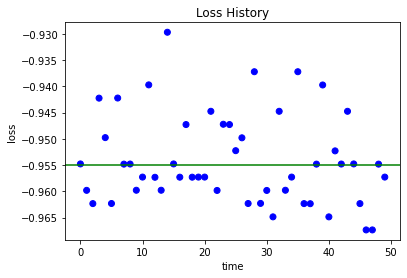

In [16]:
hpplot.main_plot_history(trials)

Showing Histogram of 50 jobs


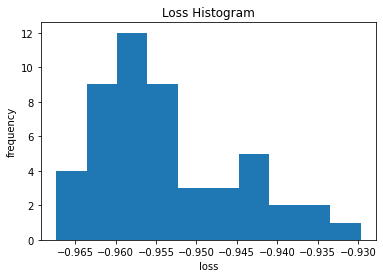

In [17]:
hpplot.main_plot_histogram(trials)

finite loss range -0.9673425989215462 -0.929691653375864 -0.9648553201184781


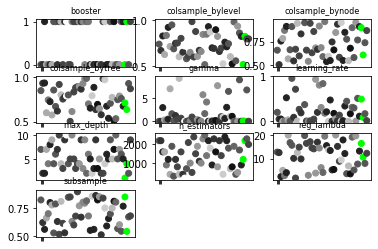

In [18]:
hpplot.main_plot_vars(
    trials,
    do_show=True,
    fontsize=8,
    colorize_best=True,
    columns=3,
    arrange_by_loss=False,
)

## Home made plots

In [19]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample,loss,loss_variance,status,index
0,1,0.716864,0.702080,0.789633,0.055281,0.002142,10.0,200.0,18.208901,0.592984,-0.929692,0.015299,ok,0
1,1,0.523077,0.957595,0.973350,0.929686,0.003384,4.0,400.0,9.437515,0.752572,-0.937210,0.009236,ok,1
2,0,0.868862,0.592080,0.792908,0.021358,0.001013,2.0,1800.0,13.787979,0.859832,-0.937210,0.014085,ok,2
3,1,0.599537,0.950542,0.803276,9.198977,0.005850,4.0,400.0,12.554895,0.812435,-0.939717,0.010540,ok,3
4,0,0.600675,0.545271,0.774166,1.075415,0.001609,5.0,700.0,6.927344,0.751204,-0.939736,0.010472,ok,4


Text(0.5, 0, 'Hyperparam combination')

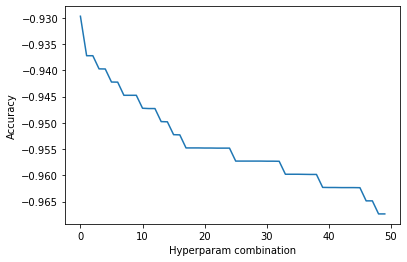

In [20]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

Text(0.5, 1.0, 'Random Search')

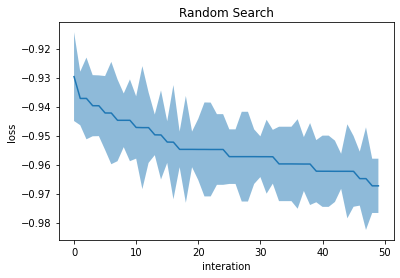

In [21]:
ax = sns.lineplot(x=r'index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('Random Search')

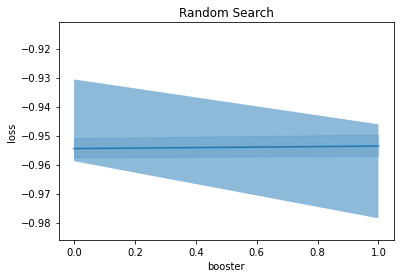

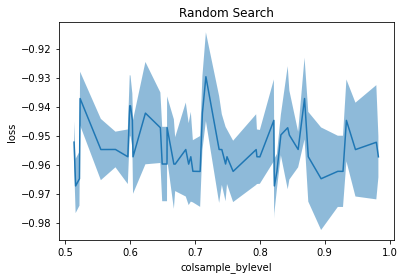

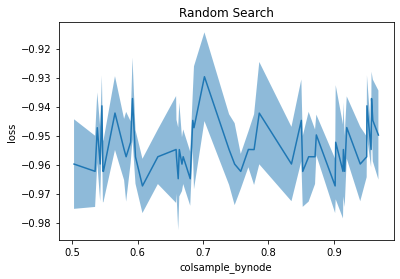

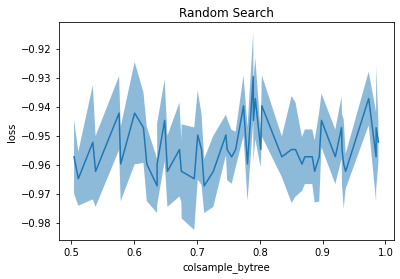

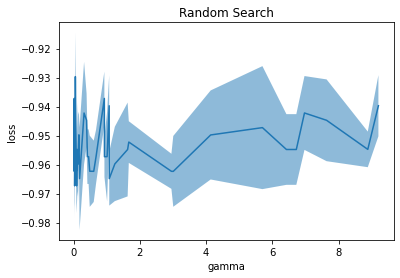

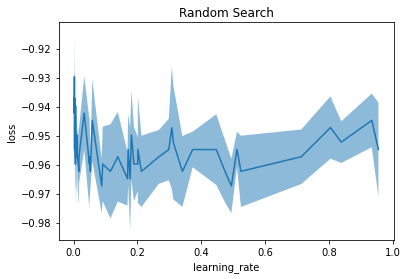

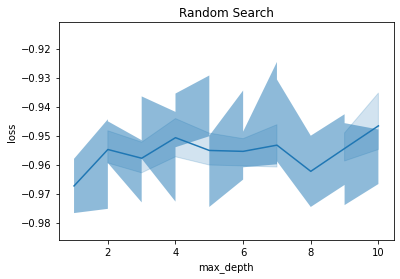

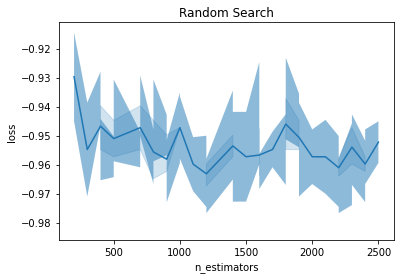

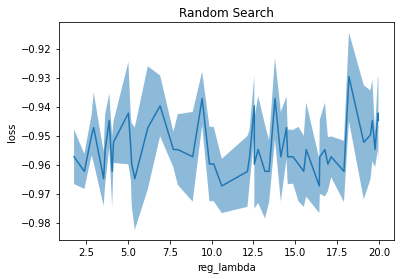

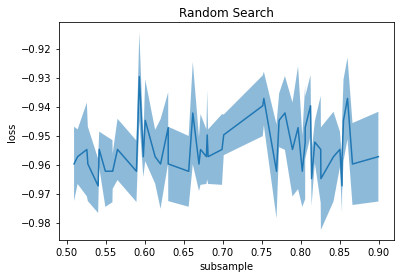

In [22]:
for var in results.columns[:-4]:
    
    tmp = results.sort_values(by=var, ascending=True)
    
    ax = sns.lineplot(x=var, y='loss', data=tmp)
    ax.fill_between(
        tmp[var],
        y1=tmp["loss"] - tmp["loss_variance"],
        y2=tmp["loss"] + tmp["loss_variance"],
        alpha=.5,
    )
    plt.xlabel(var)
    plt.title('Random Search')
    plt.show()

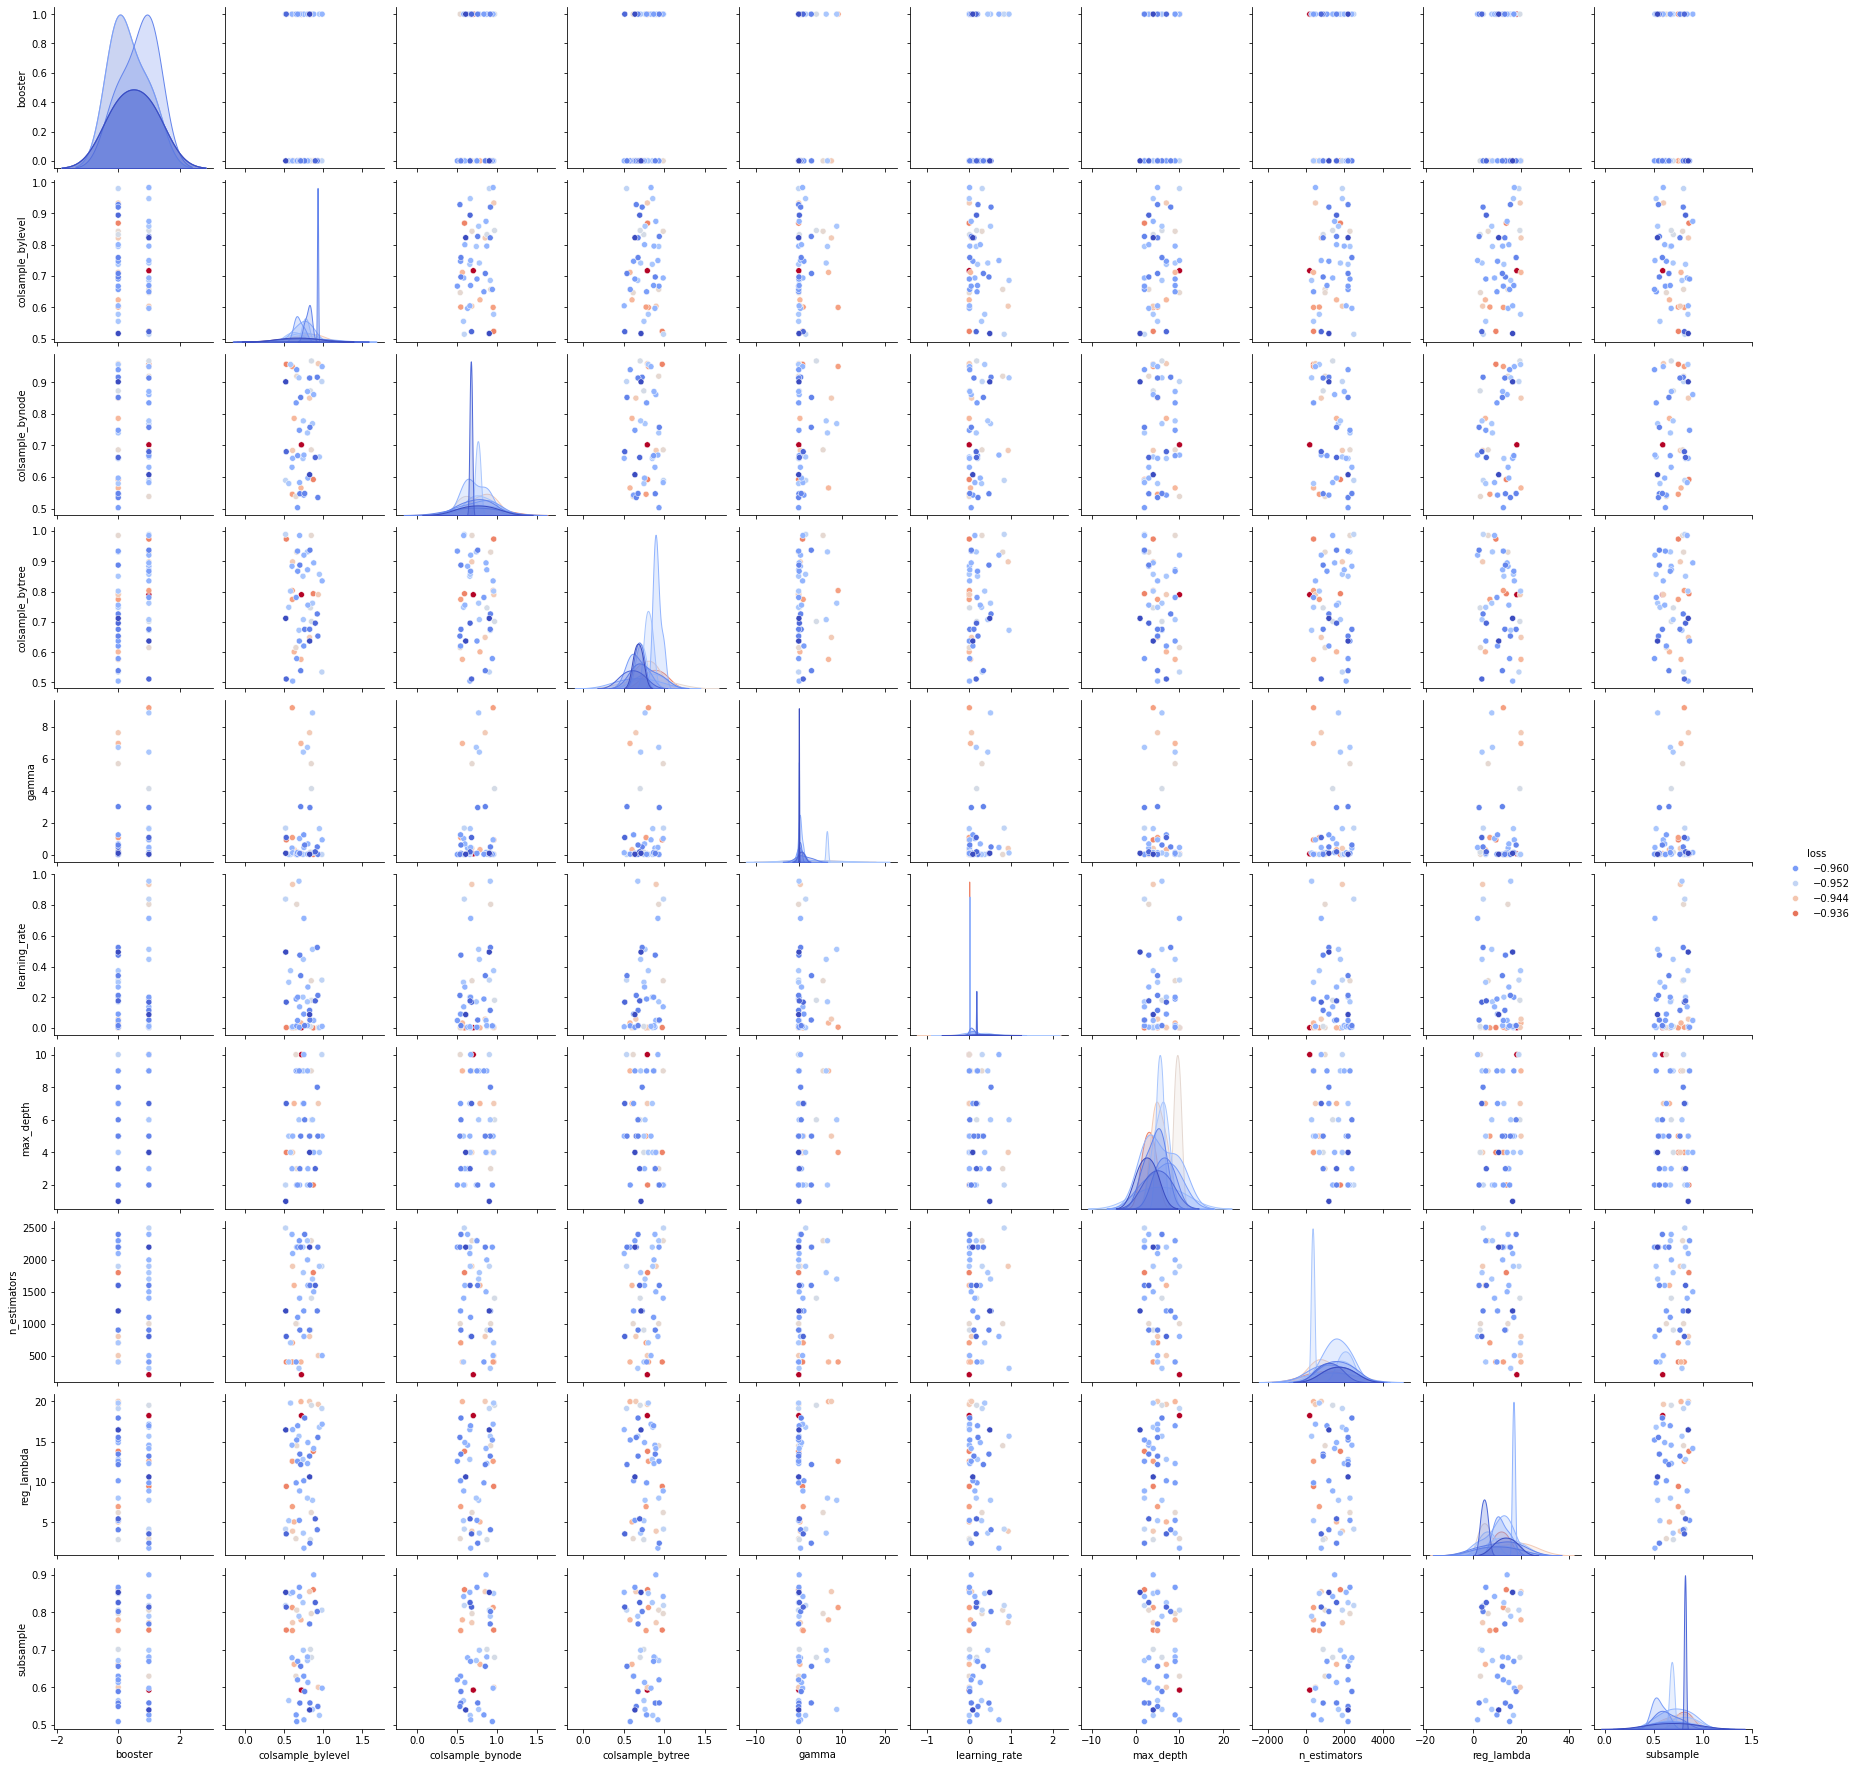

In [23]:
sns.pairplot(results[results.columns[:-3]], hue ="loss", palette ='coolwarm')
plt.show()

## TPE

**tpe**: performs TPE search for hyperparameters

In [24]:
# fmin performs the minimization
# tpe.suggest samples the parameters

trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

tpe_search

100%|████████████████████████████████████████████| 50/50 [7:27:53<00:00, 537.47s/trial, best loss: -0.9648553201184781]


{'booster': 1,
 'colsample_bylevel': 0.7603290861002258,
 'colsample_bynode': 0.6497985715113674,
 'colsample_bytree': 0.5577945635716377,
 'gamma': 0.23791313590730973,
 'learning_rate': 0.3131052896625003,
 'max_depth': 4.0,
 'n_estimators': 1500.0,
 'reg_lambda': 18.50816753530551,
 'subsample': 0.5011284761202427}

## Plotting with hyperopt

Unfortunately, the only documentation is in the source code :_(

[plotting](https://github.com/hyperopt/hyperopt/blob/master/hyperopt/plotting.py)

avg best error: -0.9559589124325967


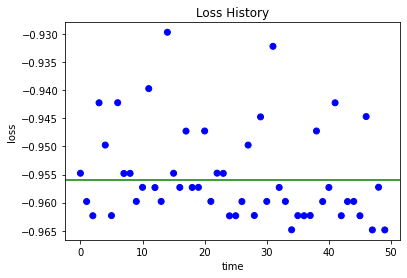

In [25]:
hpplot.main_plot_history(trials_tpe)

Showing Histogram of 50 jobs


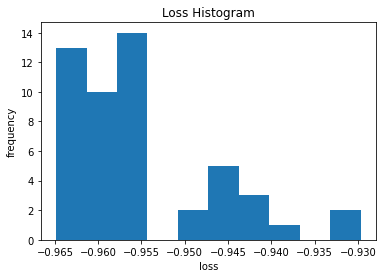

In [26]:
hpplot.main_plot_histogram(trials_tpe)

finite loss range -0.9648553201184781 -0.929691653375864 -0.9648363332573858


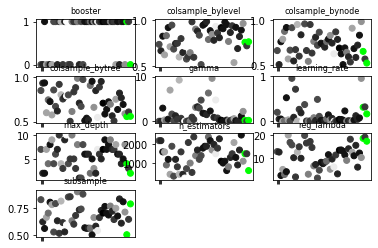

In [27]:
hpplot.main_plot_vars(
    trials_tpe,
    do_show=True,
    fontsize=8,
    colorize_best=True,
    columns=3,
    arrange_by_loss=False,
)

## Home made plots

In [28]:
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,subsample,loss,loss_variance,status,index
0,1,0.716864,0.702080,0.789633,0.055281,0.002142,10.0,200.0,18.208901,0.592984,-0.929692,0.015299,ok,0
1,1,0.933134,0.622352,0.548267,4.767003,0.001196,7.0,1500.0,6.129427,0.539399,-0.932198,0.016120,ok,1
2,1,0.599537,0.950542,0.803276,9.198977,0.005850,4.0,400.0,12.554895,0.812435,-0.939717,0.010540,ok,2
3,0,0.711479,0.565276,0.576124,6.968242,0.033009,9.0,400.0,19.942757,0.779631,-0.942223,0.012729,ok,3
4,0,0.538963,0.908632,0.752530,0.602052,0.001030,8.0,2100.0,12.530059,0.745694,-0.942242,0.017642,ok,4


Text(0.5, 0, 'Hyperparam combination')

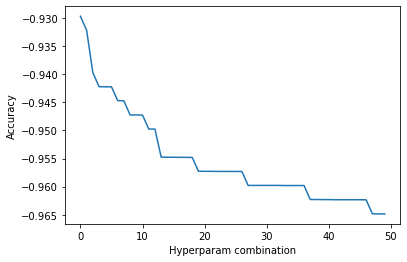

In [29]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

Text(0.5, 1.0, 'Random Search')

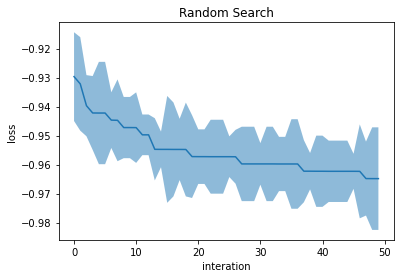

In [30]:
ax = sns.lineplot(x=r'index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('Random Search')

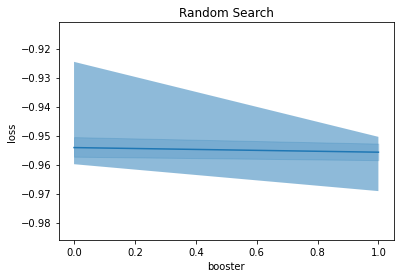

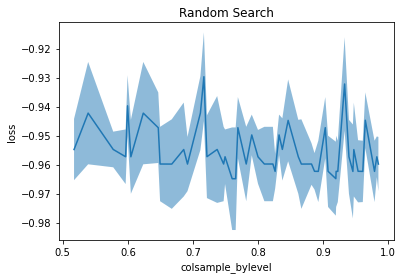

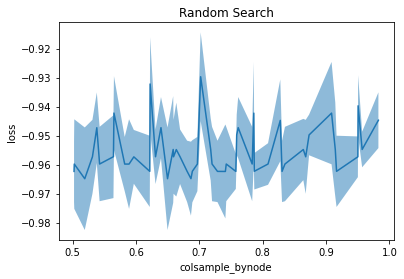

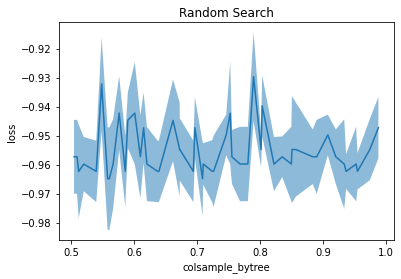

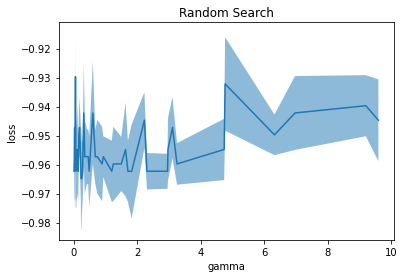

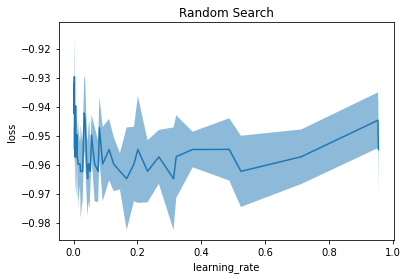

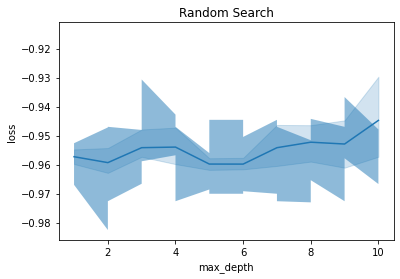

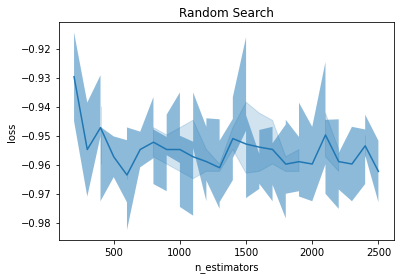

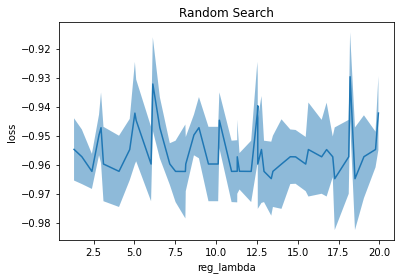

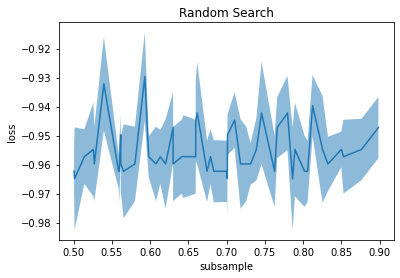

In [31]:
for var in results.columns[:-4]:
    
    tmp = results.sort_values(by=var, ascending=True)
    
    ax = sns.lineplot(x=var, y='loss', data=tmp)
    ax.fill_between(
        tmp[var],
        y1=tmp["loss"] - tmp["loss_variance"],
        y2=tmp["loss"] + tmp["loss_variance"],
        alpha=.5,
    )
    plt.xlabel(var)
    plt.title('Random Search')
    plt.show()

In [32]:
results.columns[:-2]

Index(['booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree',
       'gamma', 'learning_rate', 'max_depth', 'n_estimators', 'reg_lambda',
       'subsample', 'loss', 'loss_variance'],
      dtype='object')

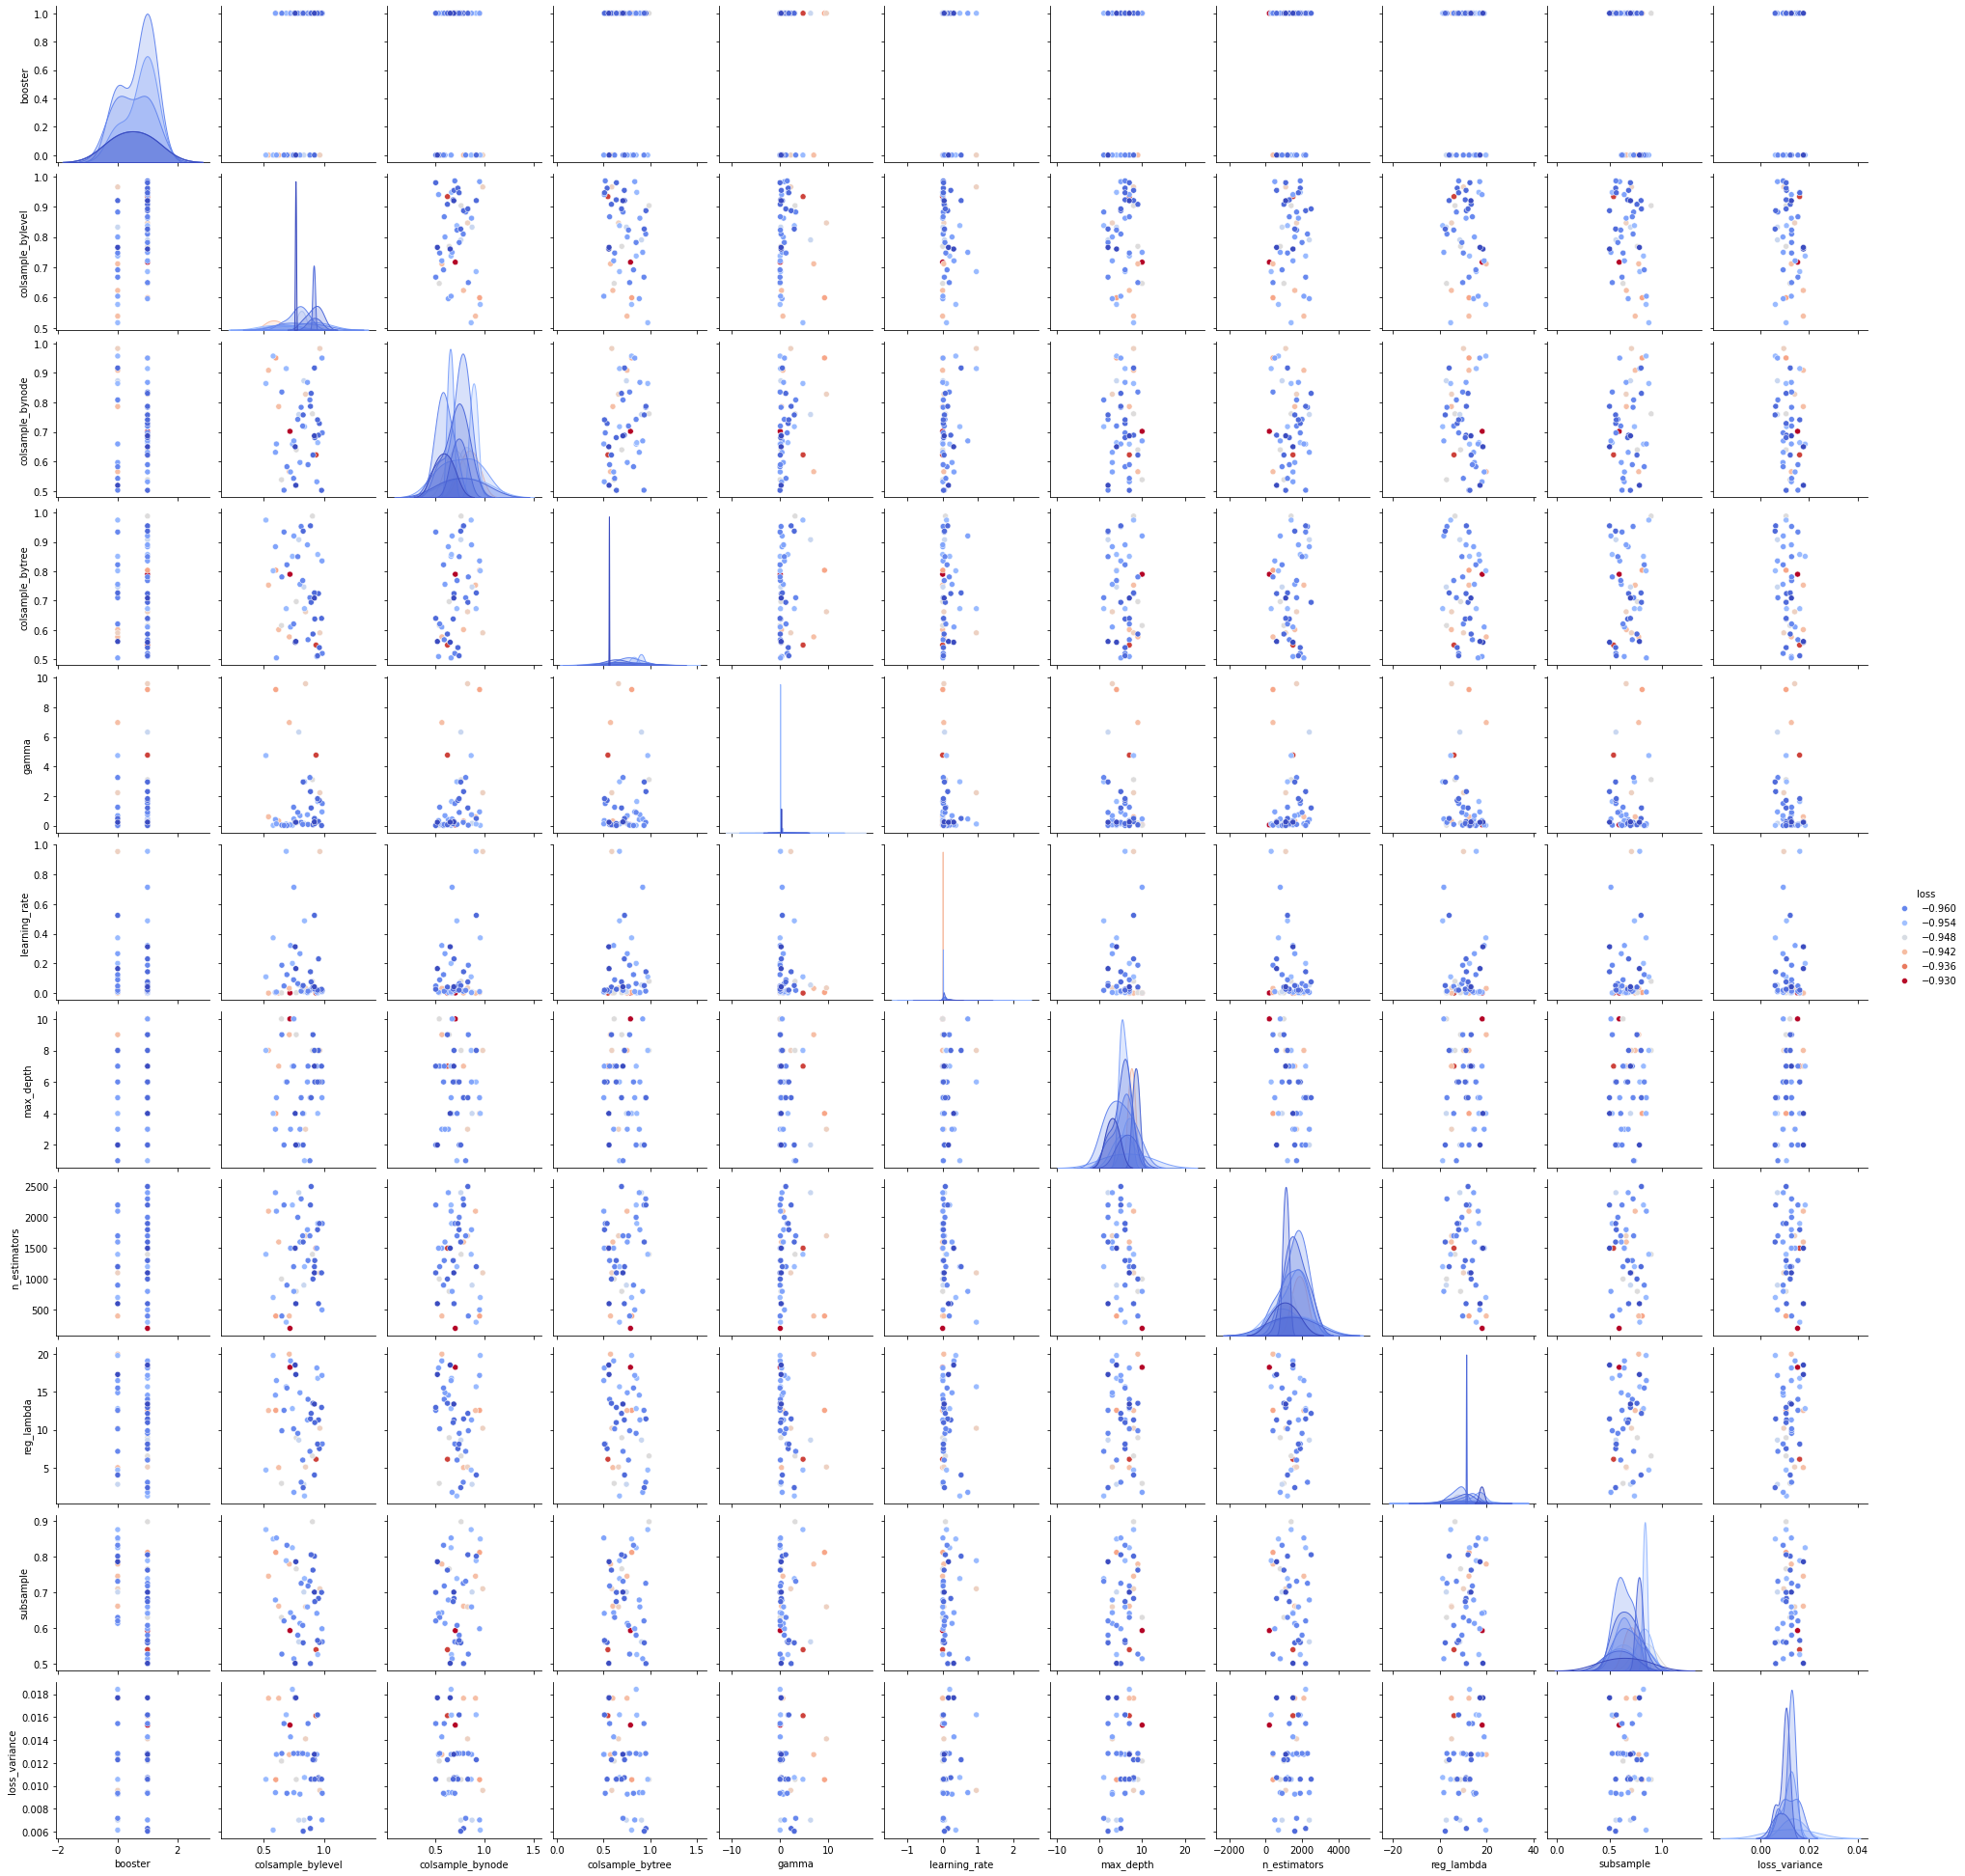

In [33]:
sns.pairplot(results[results.columns[:-2]], hue ="loss", palette ='coolwarm')
plt.show()